<h1><center>CS4243: Year 2022</center></h1>
<h4><center> Group Number: 16 </center></h4>
<h4><center> Group Member 1: Pan Yuting, Student ID </center></h4>
<h4><center> Group Member 2: Zhang Simian, A0204709H </center></h4>
<h4><center> <img src="nus.png"> </center></h4>

Food is an essential part of people’s life, and a symbol of culture for many ethnicities and countries. In Singapore, there are over a hundred hawker centres and many more coffee shops which offer people cheap and convenient access to food. Among all of such food places, one type of stalls is the most ubiquitous – Mixed Vegetable Rice, or *Cai Fan (菜饭)*. Unlike most other types of stalls that provide menus with explicit dish names, *Cai Fan* stall displays a wide array of cooked Chinese dishes without labelling their names or ingredients. Therefore, while *Cai Fan* stall provides affordability, variety and efficiency for customers, many are not well aware of the dish they are ordering. This creates several problems, including **loss of cultural heritage** when people order by saying “this” and “that” without knowing the dish name, and **over/under-estimation of the calorie intake** without knowing the dish ingredients.


Our group is planning to tackle these problems by applying neural networks to help people classify the dishes at Cai Fan stalls. We collected image data for a few popular Cai Fan dishes by using a **self-designed image scraper** on Google Image Search, which includes:
- Sweet_Sour_Pork
- Kung_Pau_Chicken
- Steamed_Fish_Fillet
- Stir_Fried_Broccoli
- Tomato_Omelette
- Cereal_Prawn
- Steamed_Egg
- Stir_Fried_Cabbage
- Curry_Chicken
- Stir_Fried_Beansprout
- Ma_Po_Tofu
- Braised_Pork_Trotter
- Stir_Fried_Pork_Liver

The image scrapper can be found [here](https://github.com/willpyt98/CS4243_Project/blob/main/Image_scrapping.ipynb). However, we **DO NOT** recommend running the image scrapper as the search results on Google could change from time to time. Instead, please refer to [this link](https://drive.google.com/drive/folders/1x5c_OMtmw6l3DdkzssaWkzguKHIJoC_p?usp=sharing) for images used in the project.


Unfortunately, there are no coordinates of bounding boxes that contain the dish in the images, and manually labelling the coordinates would be too much of a labour-demanding task. Therefore, we decided to use weakly supervised training with **class activation map** to help locate the dish in images. As a consequence of using CAM, the architecture of our classifications models is adjusted according to be compatible with **CAM**.

## 1. Utility Functions
* Data Loading
* Model Training & Saving

## 2. Exploratory Data Analysis (EDA)
## 3. Classification Models
* Multi-Layer Perception (MLP)
* Basic CNN
* VGG16
* ResNet18

## 4. Model Training Results

## 5. Class Activation Map (CAM)

In [2]:
import pylab as plt
import imageio
import os
import numpy as np
import pandas as pd
import time
import utils
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms

from torch.autograd import Function
from torch.autograd import Variable

from skimage.transform import resize
import cv2
from PIL import Image

## 1. Utility Functions

### Data Loading

#### path_label_loader: This is to load the image paths and associated labels in order, given the main data folder path

In [3]:
def path_label_loader(path):
    """
    Args:
     path: Folder path containing subfolders of images
    Output:
     images: List of image path
     labels: Numpy array of labels
    """
    images = []
    labels = []
    label_dict = {}
    
    for s_folder in os.listdir(path):
        label = int(''.join([s for s in s_folder if s.isdigit()]))
        label_word = ''.join([s for s in s_folder if not s.isdigit()])
        label_dict[label-1] = label_word
        img_folder = os.path.join(path, s_folder)
        
        for img in os.listdir(img_folder):
            if img.endswith(".jpg"):
                image_path = os.path.join(img_folder, img)
                images.append(image_path)
                labels.append(label)
                
    labels = np.array(labels) - 1
    images = np.array(images)
                
    return images, labels, label_dict

#### CustomImageDataset

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir,labels, transform = False):
        self.img_dir = img_dir
        self.transform = transform
        self.labels = labels


    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        # img = read_image(img_path, ImageReadMode.RGB).float()
        img = Image.open(img_path).convert('RGB')
        if self.transform != False:
            img = self.transform(img)
        label = self.labels[idx]
        
        return img, label

#### create_data_loader

In [9]:
def create_data_loader(img_path, img_label, batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size = (128,128)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
        
    
    dataset = CustomImageDataset(img_path, img_label, transform)

    data_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )
    
    return data_loader

#### standard_image

In [13]:
def standard_image(img_arr):
    img_out = img_arr - img_arr.min()
    img_out = img_out / img_arr.max()
    return img_out

### Model Training

#### train_model
Standard Model Training Procedures with specified *learning rate*, *train_loader*, *test_loader*

In [10]:
def train_model(net, n_epoch, my_lr, train_loader, test_loader, is_cnn = True, momentum=0.9, verbose=1):
    """
    Train a given model with specified hyperparameters
    
    Args:
     net: NN model to be trained
     n_epoch: Number of epochs to train the model
     bs: Batch size for minibatch GD
     lr: Learning rate of GD
     train_data: Torch tensor of dim [N:rgb:width:height]
     train_label: Torch tensor of dim [N]
     verbose: Print out metrics during training if 1, default 1
    
    Output:
     net: Trained NN model
     records: Dictionary containing metrics history, including training loss/error for each epoch/minibatch, test error for each epoch
    """
    
    N = len(train_loader)
    
    net = net.to(device)
    
    train_loss_hist_mb = []
    train_loss_hist = []
    train_error_hist = []
    test_error_hist = []
    
    start=time.time()

    for epoch in range(1,n_epoch+1):

        if not (epoch+1)%10:
            my_lr = my_lr / 1.5

        # optimizer=torch.optim.SGD( net.parameters() , lr=my_lr, momentum=momentum )
        optimizer=torch.optim.Adam(net.parameters(), lr=my_lr)

        running_loss=0
        running_error=0
        num_batches=0
            
        for minibatch_data, minibatch_label in train_loader:


            # FORWARD AND BACKWARD PASS
            bs = minibatch_label.shape[0]

            optimizer.zero_grad()


            minibatch_data=minibatch_data.to(device)                
            minibatch_label=minibatch_label.to(device)

            if is_cnn:
                inputs = minibatch_data
            else:                    
                inputs = minibatch_data.view(bs, 128*128*3)


            inputs.requires_grad_()

            scores=net( inputs ) 

            loss =  criterion( scores , minibatch_label.long()) 

            loss.backward()
            
            optimizer.step()


            # COMPUTE STATS
            running_loss += loss.detach().item()

            error = utils.get_error( scores.detach() , minibatch_label)
            running_error += error.item()

            num_batches+=1   
            train_loss_hist_mb.append(running_error/num_batches)
                
        # AVERAGE STATS THEN DISPLAY
        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        elapsed = (time.time()-start)/60

        if verbose == 1:
            print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        test_error = eval_on_test_set(net, test_loader,is_cnn = is_cnn, verbose=verbose) 
        
        train_loss_hist.append(total_loss)
        train_error_hist.append(total_error)
        test_error_hist.append(test_error)
    
    records = {'train_loss_mb': train_loss_hist_mb,
              'train_loss': train_loss_hist,
              'train_error': train_error_hist,
              'test_error': test_error_hist}
        
    return records

#### eval_on_test_set
This is to report the evaluation metrics on test set at the end of each training epoch

In [6]:
def eval_on_test_set(net, test_loader,is_cnn = True, verbose=1):
    
    total_error = 0
    batch_num = 0
    
    for test_data, test_label in test_loader:
        
        bs = test_label.shape[0]
        test_data=test_data.to(device)
        test_label=test_label.to(device)
        
        if is_cnn:
            inputs = test_data
        else:
            inputs = test_data.view(bs, 128*128*3)
        
        scores=net( inputs ) 

        error = utils.get_error( scores , test_label)

        total_error += error.item()
        
        batch_num += 1
        
    total_error = total_error / batch_num
    
    if verbose == 1:
        print( 'error rate on test set =', total_error*100 ,'percent\n')
        
    return total_error

#### save_net & load_net
These are used to save and load models for reuse

In [11]:
def save_net(net, path):
    torch.save(net.state_dict(), path)

In [12]:
def load_net(model, path):
    model = TheModelClass(*args, **kwargs)
    model.load_state_dict(torch.load(path))
    model.eval()

## 2. EDA

In [35]:
path = "../data/clean_images_index"
images, labels, label_dict = path_label_loader(path)
n_class = len(np.unique(labels))
print('The number of images is: ', len(images))
print('The number of labels is: ', len(labels))
print('The number of classes is:', n_class)

The number of images is:  2061
The number of labels is:  2061
The number of classes is: 13


In [31]:
label_df = pd.DataFrame(data=label_dict.items())
label_df = label_df.sort_values(0).set_index(0)
label_df = label_df.rename(columns={1:'Dish_Name'}).rename_axis('Number')
label_counts = pd.DataFrame(np.unique(labels, return_counts=True)).T
label_df['Num_Image'] = label_counts[1]
print(label_df)

                    Dish_Name  Num_Image
Number                                  
0             Sweet_Sour_Pork        156
1            Kung_Pau_Chicken        152
2         Steamed_Fish_Fillet        156
3         Stir_Fried_Broccoli        170
4             Tomato_Omelette        150
5                Cereal_Prawn        129
6                 Steamed_Egg        178
7          Stir_Fried_Cabbage        141
8               Curry_Chicken        185
9       Stir_Fried_Beansprout        159
10                 Ma_Po_Tofu        152
11       Braised_Pork_Trotter        161
12      Stir_Fried_Pork_Liver        172


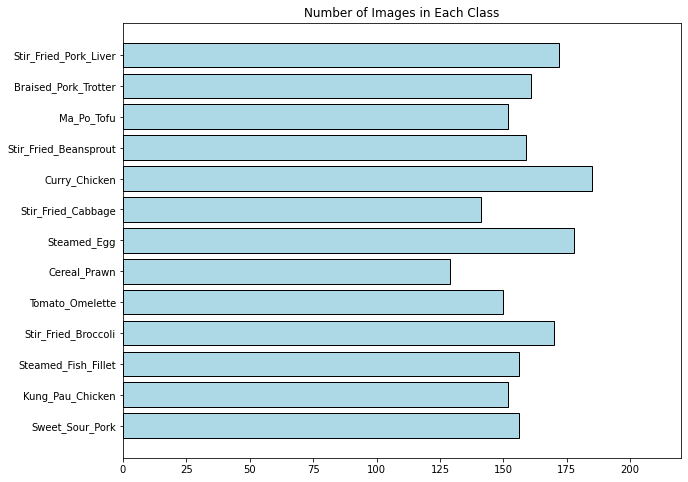

In [32]:
plt.figure(figsize=(10,8))
plt.barh(y=label_df.index, width=label_df['Num_Image'], color='lightblue', edgecolor='black')
plt.yticks(ticks=label_df.index, labels=label_df['Dish_Name'])
plt.xlim((0, 220))
plt.title('Number of Images in Each Class');

Dish Display


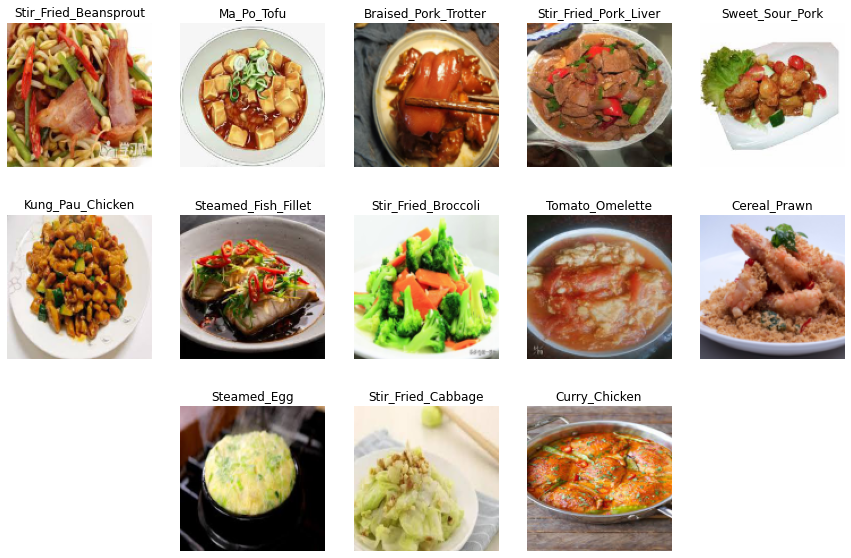

In [33]:
seen_label = []

plt.figure(figsize=(15,10))
for i, l in enumerate(labels):
    pos = 0
    if pos == 13:
        break
    if l not in seen_label:
        seen_label.append(l)
        pos = len(seen_label)
        # image_arr = Image.open(images[i]).convert('RGB')
        image_arr = imageio.imread(images[i]).astype(float)
        image_arr = resize(image_arr, (128,128))
        if pos > 10:
            pos += 1
        plt.subplot(3,5, pos)
        plt.imshow(standard_image(image_arr))
        plt.title(label_df['Dish_Name'][l])
        plt.axis("off")
print("Dish Display")

In [22]:
# Use 1648 images as training set and 413 images as test set
train_indice = np.random.choice(2061, 1648, replace=False)
train_path = images[train_indice]
train_label = labels[train_indice]
test_path = images[~train_indice]
test_label = labels[~train_indice]

In [23]:
train_loader = create_data_loader(train_path, train_label, 32)
test_loader = create_data_loader(test_path, test_label, 32)
criterion = nn.CrossEntropyLoss()

## 3. Classification Models

### MLP

In [9]:
class mlp(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(mlp , self).__init__()
        
        self.layer1 = nn.Linear(  input_size   , hidden_size1)
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2)
        self.layer3 = nn.Linear(  hidden_size2 , output_size)
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = torch.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

### Self-designed CNN

In [10]:
class CNN(nn.Module):
    def __init__(self,num_feature=32):
        super(CNN,self).__init__()
        self.num_feature=num_feature
        
        self.layer = nn.Sequential(
            # 3x128x128 -> 32*128*128
            nn.Conv2d(3,self.num_feature,3,1,1),
            nn.BatchNorm2d(self.num_feature),
            nn.ReLU(),
            # 32x128x128 -> 32x64x64
            nn.AvgPool2d(2,2), # Added
            # 32x64x64 -> 64x64x64
            nn.Conv2d(self.num_feature,self.num_feature*2,3,1,1),
            nn.BatchNorm2d(self.num_feature*2),
            nn.ReLU(),
            # 64x64x64 -> 64x32x32
            nn.AvgPool2d(2,2),
            
            # 64x32x32 -> 128x32x32
            nn.Conv2d(self.num_feature*2,self.num_feature*4,3,1,1),
            nn.BatchNorm2d(self.num_feature*4),
            nn.ReLU(),
            # 128x32x32 -> 128x16x16
            nn.AvgPool2d(2,2),
            
            # 128x16x16 -> 256x16x16
            nn.Conv2d(self.num_feature*4,self.num_feature*8,3,1,1),
            nn.BatchNorm2d(self.num_feature*8),
            nn.ReLU(),
            

            

        )
        self.avg_pool = nn.Sequential(
            nn.AvgPool2d(16,16)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(self.num_feature*8,13)
        )       
        
    def forward(self,x):
        bz = x.size()[0]
        out = self.layer(x) # (bz, 256, 16, 16)
        out = self.avg_pool(out)
        out = out.view(bz, self.num_feature*8)
        out = self.fc_layer(out) 

        return out

### VGG16

In [12]:
class VGG16(nn.Module):

    def __init__(self):

        super(VGG16, self).__init__()
        
        self.layer = nn.Sequential(
            # CL1:   3 * 128 x 128  -->    65 x 128 x 128 
            nn.Conv2d(3,   64,  kernel_size=3,  padding=1 ),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # CL2: 64 x 128 x 128 -->    64 x 128 x 128
            nn.Conv2d(64,   64,  kernel_size=3,  padding=1 ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # MP1: 64 x 128 x 128 -->    64 x 64 x 64
            nn.MaxPool2d(2,2),
            
            # CL3: 64 x 64 x 64  -->    128 x 64 x 64 
            nn.Conv2d(64,  128,  kernel_size=3,  padding=1 ),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # CL4: 128 x 64 x 64  -->    128 x 64 x 64 
            nn.Conv2d(128,  128,  kernel_size=3,  padding=1 ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # MP2: 128 x 64 x 64 -->    128 x 32 x 32
            nn.MaxPool2d(2,2),
            
            # CL5: 128 x 32 x 32  -->    256 x 32 x 32 
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # CL6: 256 x 32 x 32  -->    256 x 32 x 32     
            nn.Conv2d(256,256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # MP3: 256 x 32 x 32 -->    256 x 16 x 16
            nn.MaxPool2d(2,2),
            
            # CL7: 256 x 16 x 16  -->    512 x 16 x 16
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            # CL8: 512 x 16 x 16  -->    512 x 16 x 16
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            
        )
        
        self.avg_pool = nn.Sequential(
            nn.AvgPool2d(16,16)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(512, 13),
        )



    def forward(self, x):
        bz = x.size()[0]
        out = self.layer(x) # (bz, 256, 16, 16)
        out = self.avg_pool(out)
        out = out.view(bz, 512)
        out = self.fc_layer(out) 
    
        return out

### ResNet 18

In [13]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

    
class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=13):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
                    
            # resblock 1
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False),
            
            # resblock 2
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False),
            
            # resblock 3
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False),
            
            # resblock 4
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(512, 13),
        )

    def forward(self, x):
        bz = x.size()[0]
        out = self.layer(x) # (bz, 256, 16, 16)
        out = self.avg_pool(out)
        out = out.view(bz, 512)
        out = self.fc_layer(out) 

        return out

## 4. Model Training Results

### Train with MPL

In [18]:
my_mlp=mlp(128*128*3, 50, 50, 13)
my_mlp.to(device)
print(my_mlp)

mlp(
  (layer1): Linear(in_features=49152, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=13, bias=True)
)


In [19]:
mlp_record = train_model(net = my_mlp, n_epoch = 10, my_lr = 1e-4, train_loader = train_loader, test_loader = test_loader,is_cnn = False, verbose=1)

epoch= 1 	 time= 0.1218672792116801 min 	 lr= 0.0001 	 loss= 130.78913795489532 	 error= 91.58653846153845 percent
error rate on test set = 92.60817307692307 percent

epoch= 2 	 time= 0.302167812983195 min 	 lr= 0.0001 	 loss= 2.5638479590415955 	 error= 92.3076923076923 percent
error rate on test set = 90.5048076923077 percent

epoch= 3 	 time= 0.452560301621755 min 	 lr= 0.0001 	 loss= 2.56340505526616 	 error= 91.5264423076923 percent
error rate on test set = 90.32451923076923 percent

epoch= 4 	 time= 0.6365116715431214 min 	 lr= 0.0001 	 loss= 2.5629477225817165 	 error= 91.2860576923077 percent
error rate on test set = 90.38461538461539 percent

epoch= 5 	 time= 0.815853766600291 min 	 lr= 0.0001 	 loss= 2.562707713017097 	 error= 91.22596153846155 percent
error rate on test set = 90.38461538461539 percent

epoch= 6 	 time= 0.9942144433657328 min 	 lr= 0.0001 	 loss= 2.56248978468088 	 error= 91.22596153846155 percent
error rate on test set = 90.38461538461539 percent

epoch= 7 	

In [20]:
save_net(my_mlp, "mlp.pth")

### Train with self-designed CNN

In [21]:
eg_CNN = CNN()
eg_CNN.to(device)
print(eg_CNN)

CNN(
  (layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (avg_pool): Sequential(
    (0): AvgPool2d(kernel_size=16, stride=16, pa

In [22]:
cnn_record = train_model(net = eg_CNN, n_epoch = 30, my_lr = 1e-3, train_loader = train_loader, test_loader = test_loader, verbose=1)

epoch= 1 	 time= 0.1435711622238159 min 	 lr= 0.001 	 loss= 2.014387600697004 	 error= 65.7451923076923 percent
error rate on test set = 55.588942307692314 percent

epoch= 2 	 time= 0.38478694756825765 min 	 lr= 0.001 	 loss= 1.7479388759686396 	 error= 58.05288461538461 percent
error rate on test set = 49.87980769230769 percent

epoch= 3 	 time= 0.6778510808944702 min 	 lr= 0.001 	 loss= 1.5790471824315877 	 error= 52.40384615384615 percent
error rate on test set = 48.49759615384615 percent

epoch= 4 	 time= 0.9722242633501689 min 	 lr= 0.001 	 loss= 1.494137974885794 	 error= 50.300480769230774 percent
error rate on test set = 46.09375 percent

epoch= 5 	 time= 1.2662579774856568 min 	 lr= 0.001 	 loss= 1.40600251692992 	 error= 45.793269230769226 percent
error rate on test set = 43.20913461538461 percent

epoch= 6 	 time= 1.5615727424621582 min 	 lr= 0.001 	 loss= 1.3600343316793442 	 error= 45.13221153846153 percent
error rate on test set = 39.66346153846153 percent

epoch= 7 	 tim

In [23]:
save_net(eg_CNN, "simple_cnn.pth")

### Train with VGG-16

In [29]:
my_VGG16 = VGG16()
my_VGG16.to(device)
print(my_VGG16)

VGG16(
  (layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [30]:
VGG_record = train_model(net = my_VGG16, n_epoch = 30, my_lr = 1e-4, train_loader = train_loader, test_loader = test_loader,is_cnn = True, verbose=1)

epoch= 1 	 time= 0.1868393818537394 min 	 lr= 0.0001 	 loss= 1.8455197765276983 	 error= 60.817307692307686 percent
error rate on test set = 52.76442307692307 percent

epoch= 2 	 time= 0.4715275843938192 min 	 lr= 0.0001 	 loss= 1.5327491576855 	 error= 48.67788461538461 percent
error rate on test set = 39.84375 percent

epoch= 3 	 time= 0.7627179145812988 min 	 lr= 0.0001 	 loss= 1.3589755044533656 	 error= 43.32932692307692 percent
error rate on test set = 36.237980769230774 percent

epoch= 4 	 time= 1.067507803440094 min 	 lr= 0.0001 	 loss= 1.244618302354446 	 error= 38.581730769230774 percent
error rate on test set = 34.43509615384615 percent

epoch= 5 	 time= 1.3730268359184266 min 	 lr= 0.0001 	 loss= 1.1436340453533025 	 error= 35.03605769230769 percent
error rate on test set = 28.90625 percent

epoch= 6 	 time= 1.6838570753733317 min 	 lr= 0.0001 	 loss= 1.0622483732608647 	 error= 31.009615384615387 percent
error rate on test set = 27.103365384615387 percent

epoch= 7 	 time=

In [31]:
save_net(my_VGG16, "vgg16.pth")

### Train with Resnet

In [32]:
my_ResNet18 = ResNet18(3, ResBlock)
my_ResNet18.to(device)
print(my_ResNet18)

ResNet18(
  (layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [33]:
my_ResNet18 = train_model(net = my_ResNet18, n_epoch = 10, my_lr = 1e-4, train_loader = train_loader, test_loader = test_loader,is_cnn = True, verbose=1)

epoch= 1 	 time= 0.2126059095064799 min 	 lr= 0.0001 	 loss= 2.015839872451929 	 error= 68.26923076923077 percent
error rate on test set = 51.92307692307693 percent

epoch= 2 	 time= 0.5211462020874024 min 	 lr= 0.0001 	 loss= 1.1418796731875493 	 error= 33.35336538461539 percent
error rate on test set = 13.521634615384615 percent

epoch= 3 	 time= 0.8026925166447957 min 	 lr= 0.0001 	 loss= 0.3635017301600713 	 error= 8.353365384615383 percent
error rate on test set = 8.834134615384617 percent

epoch= 4 	 time= 1.1518914898236592 min 	 lr= 0.0001 	 loss= 0.16598787531256676 	 error= 3.245192307692308 percent
error rate on test set = 8.954326923076923 percent

epoch= 5 	 time= 1.5069618980089823 min 	 lr= 0.0001 	 loss= 0.10124708404048131 	 error= 1.9831730769230769 percent
error rate on test set = 9.735576923076923 percent

epoch= 6 	 time= 1.859419333934784 min 	 lr= 0.0001 	 loss= 0.09881041657466155 	 error= 2.283653846153846 percent
error rate on test set = 9.615384615384617 perc

In [34]:
save_net(my_ResNet18, "resnet18.pth")

AttributeError: 'dict' object has no attribute 'state_dict'

### Save Models

In [ ]:
#import pickle
#file_to_store = open("cnn.pickle", "wb")
#pickle.dump(eg_CNN, file_to_store)


#file_to_store.close()

In [ ]:
#import pickle
#file_to_read = open("cnn.pickle", "rb")

#eg_CNN = pickle.load(file_to_read)

#file_to_read.close()

In [ ]:
# import pickle
# file_to_store = open("lenet.pickle", "wb")
# pickle.dump(my_lenet, file_to_store)


# file_to_store.close()

In [ ]:
# import pickle
# file_to_read = open("lenet.pickle", "rb")

# my_lenet = pickle.load(file_to_read)

# file_to_read.close()

## 5. Class Activation Map (CAM)

In [35]:
model = my_VGG16
params = list(model.fc_layer.parameters())
weight = np.squeeze(params[0].cpu().data.numpy())
print('weight.shape', weight.shape)

weight.shape (13, 512)


In [39]:
image, label = next(iter(test_loader))
# image = image[0].reshape(1,3,128,128)
# label = label[0]

model.eval()
scores = model(image.cuda()) # get the raw scores
probs = torch.nn.functional.softmax(scores, dim=1).data.squeeze() # use softmax to generate the probability distribution for the scores
probs, idx = probs.sort(-1, True) # sort the probability distribution in descending order, and idx[0] is the predicted class
print('sum of probabilities: %.0f'%torch.sum(probs.cpu().data).numpy())
print('true class: ', label.cpu().numpy())
print('predicated class: ', idx[:,0].cpu().numpy())

sum of probabilities: 32
true class:  [ 4 11  6 11 12  9 12  2  3  7  6  6  1  9 10  9  4  6  7  2  8  8 11  2
  8  4  9  9  2  2  9  8]
predicated class:  [ 4 11  6 11 12  9 12  2  3  7  6  6  1  9 10  9  4  6  7  2  8  8 11  2
  8  4  9  9  2  2  9  8]


In [40]:
feature_maps = model.layer(image.cuda())
feature_maps.shape

torch.Size([32, 512, 16, 16])

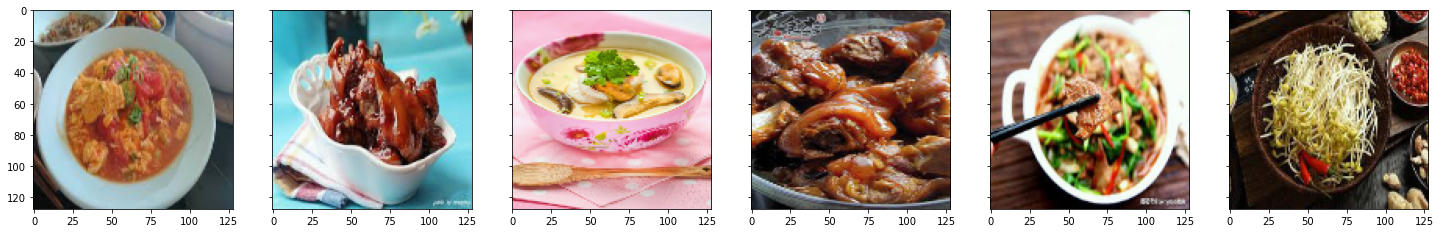

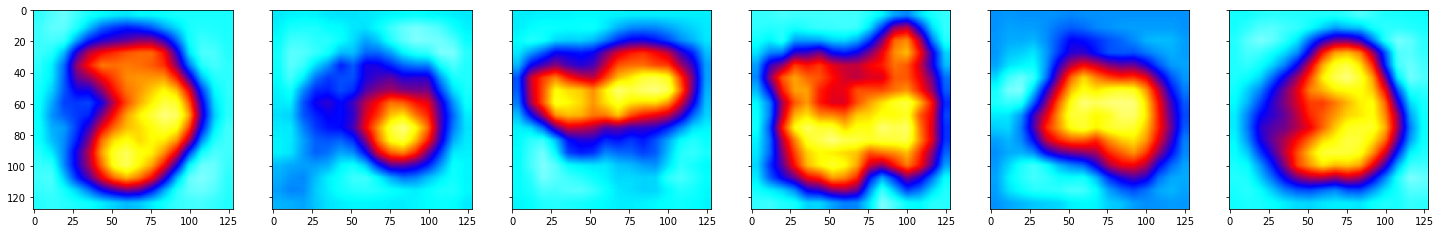

In [41]:
def return_CAM(feature_conv, weight, class_idx):
    """
    return_CAM generates the CAMs and up-sample it to 224x224
    arguments:
    feature_conv: the feature maps of the last convolutional layer
    weight: the weights that have been extracted from the trained parameters
    class_idx: the label of the class which has the highest probability
    """
    size_upsample = (128, 128)
    
    # we only consider one input image at a time, therefore in the case of 
    # VGG16, the shape is (1, 512, 7, 7)
    bz, nc, h, w = feature_conv.shape 
    output_cam = []
    i = 0
    for idx in class_idx:
        # print('idx', idx)
        beforeDot =  feature_conv[i].reshape((nc, h*w))# -> (100, 32*32)
        # print('beforeDot.shape', beforeDot.shape)
        #weight_reshaped = weight[idx].reshape((nc, h*w)) # (100, 32*32)
        #weight_temp = np.mean(weight_reshaped, axis=-1) # (100,1)
        cam = np.matmul(weight[idx], beforeDot) # -> (1, 100) x (100,32*32) = (1,32*32)
        # print('weight.shape', weight[idx].shape)
        cam = cam.reshape(h, w) # -> (32 ,32)
        # global temp
        # temp = cam
        cam = cam.numpy()
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
        i += 1
    return output_cam


feature_maps = model.layer(image.cuda()) # get the feature maps of the last convolutional layer

CAMs = return_CAM(feature_maps.cpu().detach(), weight, idx.cpu().numpy()[:,0]) # generate the CAM for the input image

# fig, axes = plt.subplots(1,6, sharex=True, sharey=True, figsize=(25,10))

# for i, ax in enumerate(axes.flatten()):
#     disp_img = image[i]
#     disp_img = disp_img.reshape((3, 128, 128)).numpy().transpose((1, 2, 0)) 
#     ax.imshow(standard_image(disp_img))
#     true_label = label_df['Dish_Name'][label[i]]
#     ax.title(f'True Label: {true_label}')


# plt.show()

# fig, axes = plt.subplots(1,6, sharex=True, sharey=True, figsize=(25,10))

# for i, ax in enumerate(axes.flatten()):
#     heatmap = cv2.applyColorMap(CAMs[i], cv2.COLORMAP_JET) 
#     heatmap = -heatmap + heatmap.max()
#     ax.imshow(heatmap)
#     pred_label = label_df['Dish_Name'][idx[:,0].cpu().numpy()[i]]
#     ax.title(f'Pred Label: {pred_label}')
    
      
# plt.show()


for i in range(0,6):
    disp_img = image[i]
    disp_img = disp_img.reshape((3, 128, 128)).numpy().transpose((1, 2, 0)) 
    plt.subplot(2,6,i)
    plt.imshow(standard_image(disp_img))
    true_label = label_df['Dish_Name'][label[i]]
    title = 'True Label:' + true_label
    plt.title(title)


for i in range(6,12):
    heatmap = cv2.applyColorMap(CAMs[i], cv2.COLORMAP_JET) 
    heatmap = -heatmap + heatmap.max()
    plt.subplot(2,6,i)
    plt.imshow(heatmap)
    pred_label = label_df['Dish_Name'][idx[:,0].cpu().numpy()[i]]
    title = 'Pred Label:' + pred_label
    plt.title(title)
    
      
plt.show()